In [21]:
import requests
from typing import TypedDict, Dict
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from serpapi import GoogleSearch
import os

In [6]:
from dotenv import load_dotenv
import os

load_dotenv()

SERPAPI_API_KEY = os.getenv("SERPAPI_API_KEY")
print("Key loaded:", bool(SERPAPI_API_KEY))


Key loaded: True


In [8]:
class ResearchState(TypedDict):
    topic: str
    completed_sections: Dict[str, str]
    current_section: str
    human_feedback: str
    next_section: str
    citations: Dict[str, list]
class SectionContent(BaseModel):
    content: str = Field(description="Section content in markdown")
llm = ChatOpenAI(model="gpt-4o", temperature=0.7)

In [9]:

def search_academic_papers(query, SERPAPI_API_KEY, max_results=5):
    try:
        search = GoogleSearch({
            "engine": "google_scholar",
            "q": query,
            "api_key": SERPAPI_API_KEY,
            "num": 20
        })

        results = search.get_dict()
        
        if "error" in results:
            return []
        
        organic_results = results.get("organic_results", [])
        
        if not organic_results:
            return []
        
        papers = []
        seen_titles = set()

        for idx, result in enumerate(organic_results, start=1):
            title = result.get("title")
            
            if not title:
                continue
            
            # Skip duplicates
            title_normalized = title.lower().strip()
            if title_normalized in seen_titles:
                continue
            
            seen_titles.add(title_normalized)

            # Try Semantic Scholar first
            metadata = resolve_metadata_semantic_scholar(title)
            
            if metadata and metadata["authors"] and metadata["year"]:
                papers.append(metadata)
            else:
                # FALLBACK: Use Google Scholar data directly
                publication_info = result.get("publication_info", {})
                snippet = result.get("snippet", "")
                link = result.get("link", "")
                
                # Extract author
                authors_raw = publication_info.get("authors", [])
                if authors_raw:
                    authors = [a.get("name") for a in authors_raw if a.get("name")]
                else:
                    summary = publication_info.get("summary", "")
                    if summary and " - " in summary:
                        author_part = summary.split(" - ")[0]
                        authors = [author_part.strip()]
                    else:
                        authors = ["Author Unknown"]
                
                # Extract year
                year = None
                summary = publication_info.get("summary", "")
                if summary:
                    import re
                    year_match = re.search(r'\b(19|20)\d{2}\b', summary)
                    if year_match:
                        year = int(year_match.group())
                
                if not year:
                    year = "n.d."
                
                # Get source/venue
                source = publication_info.get("summary", "").split(" - ")[-1] if " - " in publication_info.get("summary", "") else "Google Scholar"
                
                gs_metadata = {
                    "title": title,
                    "authors": authors,
                    "year": year,
                    "source": source,
                    "link": link,
                    "abstract": snippet if snippet else "Abstract not available."
                }
                
                papers.append(gs_metadata)

            if len(papers) >= max_results:
                break

        return papers
        
    except Exception as e:
        return []


In [10]:
def resolve_metadata_semantic_scholar(title):
    try:
        url = "https://api.semanticscholar.org/graph/v1/paper/search"
        params = {
            "query": title,
            "limit": 1,
            "fields": "title,authors,year,venue,abstract,url"
        }

        r = requests.get(url, params=params, timeout=10)
        if r.status_code != 200:
            return None

        data = r.json().get("data", [])
        if not data:
            return None

        paper = data[0]
        authors = [a.get("name", "Unknown") for a in paper.get("authors", [])]
        
        return {
            "title": paper.get("title"),
            "authors": authors if authors else None,
            "year": paper.get("year"),
            "source": paper.get("venue", ""),
            "link": paper.get("url"),
            "abstract": paper.get("abstract", "")
        }
    except Exception as e:
        return None

In [11]:
def write_introduction(state: ResearchState):
    topic = state['topic']
    feedback = state.get('human_feedback', '')

    structured_llm = llm.with_structured_output(SectionContent)

    prompt = f"""Write the INTRODUCTION section for a research paper.

Topic: {topic}
{f"Human feedback: {feedback}" if feedback else ""}

Write 2–3 paragraphs that:
1. Introduce the topic
2. State the research problem/question
3. Outline the paper structure

Use markdown formatting.
"""
    result = structured_llm.invoke(prompt)
    completed = state.get('completed_sections', {})
    completed['introduction'] = result.content

    return {
        "completed_sections": completed,
        "current_section": "introduction",
        "next_section": "literature_review",
        "human_feedback": ""
    }

In [12]:
def write_literature_review(state: ResearchState):
    topic = state['topic']
    
    # Try multiple search strategies
    search_queries = [
        f'"{topic}"',
        f"transformational leadership Nigeria",
        f"transformational leadership Africa organizations"
    ]
    
    all_citations = []
    seen_titles = set()
    
    print("\n📚 Searching for academic papers...")
    
    for query in search_queries:
        results = search_academic_papers(query, SERPAPI_API_KEY, max_results=3)
        
        for paper in results:
            title_norm = paper['title'].lower().strip()
            if title_norm not in seen_titles:
                all_citations.append(paper)
                seen_titles.add(title_norm)
        
        if len(all_citations) >= 6:
            break
    
    citations = all_citations[:6]
    
    if citations:
        print(f"✅ Found {len(citations)} relevant papers")
    
    if not citations:
        print("⚠️  No papers found, trying broader search...")
        citations = search_academic_papers("transformational leadership", SERPAPI_API_KEY, max_results=5)
    
    if not citations:
        completed = state.get('completed_sections', {})
        completed['literature_review'] = """### Literature Review

**Note**: Unable to retrieve academic papers from external sources. This may be due to API limitations or network connectivity issues."""
        
        return {
            "completed_sections": completed,
            "current_section": "literature_review",
            "next_section": "methodology",
            "citations": {"literature_review": []}
        }
    
    # Build context
    context_list = []
    for i, cite in enumerate(citations, start=1):
        author_str = ", ".join(cite['authors'][:3])
        if len(cite['authors']) > 3:
            author_str += " et al."
        
        abstract = cite.get('abstract', '') or "Abstract not available."
        if len(abstract) > 500:
            abstract = abstract[:500] + "..."
        
        context_list.append(
            f"SOURCE ID: [{i}]\n"
            f"TITLE: {cite['title']}\n"
            f"AUTHORS: {author_str}\n"
            f"YEAR: {cite['year']}\n"
            f"SOURCE: {cite['source']}\n"
            f"ABSTRACT: {abstract}\n"
            "---"
        )

    citations_context = "\n".join(context_list)
    
    structured_llm = llm.with_structured_output(SectionContent)

    prompt = f"""You are writing the LITERATURE REVIEW for:

Topic: {topic}

PROVIDED SOURCES:
{citations_context}

RULES:
- Use ONLY provided sources
- Use inline citations like [1], [2]
- Do NOT invent findings
- Do NOT include a References section - it will be added automatically

Generate 3–4 coherent paragraphs discussing the literature.
"""

    result = structured_llm.invoke(prompt)

    # BUILD REFERENCES PROGRAMMATICALLY
    references_section = "\n### References\n\n"
    for i, cite in enumerate(citations, start=1):
        authors = cite['authors']
        if not authors:
            author_str = "Unknown Author"
        elif len(authors) == 1:
            author_str = authors[0]
        elif len(authors) == 2:
            author_str = f"{authors[0]} & {authors[1]}"
        else:
            author_str = f"{authors[0]} et al."
        
        year = cite['year'] if cite['year'] else "n.d."
        title = cite['title']
        source = cite['source'] if cite['source'] and cite['source'] != "Unknown" else ""
        link = cite['link'] if cite['link'] else ""
        
        # APA-style reference
        ref_line = f"[{i}] {author_str} ({year}). *{title}*. "
        if source:
            ref_line += f"{source}. "
        if link:
            ref_line += f"Retrieved from {link}"
        ref_line += "\n\n"
        
        references_section += ref_line

    # COMBINE CONTENT + REFERENCES
    full_content = result.content + "\n" + references_section

    completed = state.get('completed_sections', {})
    completed['literature_review'] = full_content

    return {
        "completed_sections": completed,
        "current_section": "literature_review",
        "next_section": "methodology",
        "citations": {"literature_review": citations}
    }

In [13]:
def write_methodology(state: ResearchState):
    topic = state['topic']
    
    print("\n📚 Searching for methodology papers...")
    citations = search_academic_papers(
        f"{topic} research methodology",
        SERPAPI_API_KEY
    )
    
    if citations:
        print(f"✅ Found {len(citations)} relevant papers")

    methods_text = ""
    for i, cite in enumerate(citations, start=1):
        abstract = cite.get('abstract', '') or "Abstract not available."
        methods_text += f"[{i}] {cite['title']} — {abstract}\n"
    
    structured_llm = llm.with_structured_output(SectionContent)

    prompt = f"""Write the METHODOLOGY section.

Topic: {topic}

Sources:
{methods_text}

Explain design, data collection, and analysis.
"""

    result = structured_llm.invoke(prompt)

    completed = state.get('completed_sections', {})
    completed['methodology'] = result.content

    return {
        "completed_sections": completed,
        "current_section": "methodology",
        "next_section": "results",
        "human_feedback": ""
    }


In [14]:
def write_results(state: ResearchState):
    topic = state['topic']
    
    print("\n📚 Searching for findings papers...")
    citations = search_academic_papers(
        f"{topic} findings",
        SERPAPI_API_KEY
    )
    
    if citations:
        print(f"✅ Found {len(citations)} relevant papers")

    findings_text = ""
    for i, cite in enumerate(citations, start=1):
        abstract = cite.get('abstract', '') or "Abstract not available."
        findings_text += f"[{i}] {abstract}\n"
    
    structured_llm = llm.with_structured_output(SectionContent)

    prompt = f"""Write the RESULTS section.

Topic: {topic}

Findings:
{findings_text}
"""

    result = structured_llm.invoke(prompt)

    completed = state.get('completed_sections', {})
    completed['results'] = result.content

    return {
        "completed_sections": completed,
        "current_section": "results",
        "next_section": "conclusion",
        "human_feedback": ""
    }

In [15]:
def write_conclusion(state: ResearchState):
    topic = state['topic']

    print("\n✍️  Generating conclusion and recommendations...")
    
    structured_llm = llm.with_structured_output(SectionContent)

    prompt = f"""Write the CONCLUSION and RECOMMENDATIONS section.

Topic: {topic}

Summarize findings, implications, and recommendations.
"""

    result = structured_llm.invoke(prompt)

    completed = state.get('completed_sections', {})
    completed['conclusion'] = result.content

    return {
        "completed_sections": completed,
        "current_section": "conclusion",
        "next_section": "done",
        "human_feedback": ""
    }

In [16]:
# Human review node
def human_review(state: ResearchState):
    pass

# Routing function (to respect human feedback)
def route_next(state: ResearchState):
    # If there is feedback, go back to the same section
    if state.get('human_feedback'):
        return state.get('current_section', END)

    # Otherwise, go to the next section
    next_section = state.get('next_section', '')
    next_map = {
        "literature_review": "write_literature_review",
        "methodology": "write_methodology",
        "results": "write_results",
        "conclusion": "write_conclusion",
        "done": END
    }
    return next_map.get(next_section, END)

In [17]:
# Build graph with human review
builder = StateGraph(ResearchState)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_literature_review", write_literature_review)
builder.add_node("write_methodology", write_methodology)
builder.add_node("write_results", write_results)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("human_review", human_review)

# Add edges
builder.add_edge(START, "write_introduction")
builder.add_edge("write_introduction", "human_review")
builder.add_edge("write_literature_review", "human_review")
builder.add_edge("write_methodology", "human_review")
builder.add_edge("write_results", "human_review")
builder.add_edge("write_conclusion", "human_review")

builder.add_conditional_edges(
    "human_review",
    route_next,
    ["write_introduction", "write_literature_review", "write_methodology",
     "write_results", "write_conclusion", END]
)


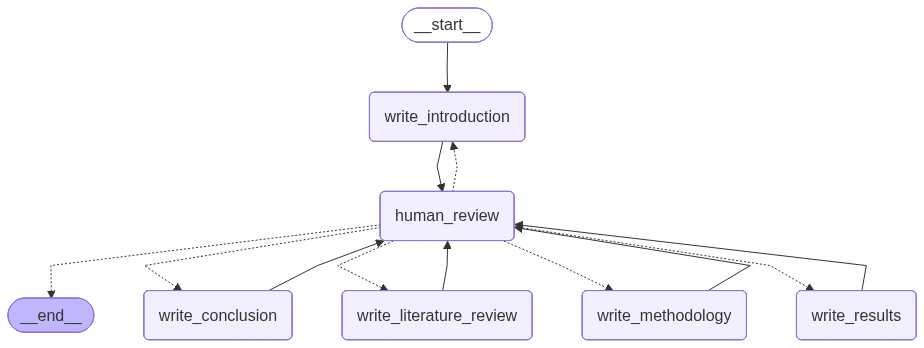

In [18]:
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_review'], checkpointer=memory)
#main_graph = builder.compile()
from IPython.display import Image, display

display(Image(main_graph.get_graph(xray=1).draw_mermaid_png()))

In [26]:
from datetime import datetime

if __name__ == "__main__":
    print("="*70)
    print("RESEARCH PAPER GENERATOR")
    print("="*70)
    
    topic = "The Impact of transformational leadership in Oyo State, Nigeria"
    print(f"\n📝 Topic: {topic}\n")

    initial_state = {
        "topic": topic,
        "completed_sections": {},
        "current_section": "",
        "human_feedback": "",
        "next_section": "",
        "citations": {}
    }

    thread = {"configurable": {"thread_id": "research-1"}}
    displayed_sections = set()
    
    # IMPORTANT: Track the final state
    final_state = initial_state

    # Initial run
    for event in graph.stream(initial_state, thread, stream_mode="values"):
        sections = event.get('completed_sections', {})
        current = event.get('current_section', '')
        
        # UPDATE: Capture the latest state
        final_state = event
        
        if current and current in sections and current not in displayed_sections:
            print(f"\n{'='*70}")
            print(f"  {current.upper().replace('_', ' ')}")
            print(f"{'='*70}")
            print(sections[current])
            displayed_sections.add(current)

    # Loop for feedback / next sections
    while True:
        feedback = input("\n💬 Feedback (press Enter to continue): ").strip()
        has_output = False

        for event in graph.stream({"human_feedback": feedback} if feedback else None, thread, stream_mode="values"):
            sections = event.get('completed_sections', {})
            current = event.get('current_section', '')
            next_sec = event.get('next_section', '')
            
            # UPDATE: Keep capturing the latest state
            final_state = event

            if current and current in sections:
                if feedback or current not in displayed_sections:
                    print(f"\n{'='*70}")
                    print(f"  {current.upper().replace('_', ' ')}")
                    print(f"{'='*70}")
                    print(sections[current])
                    displayed_sections.add(current)
                    has_output = True

            if next_sec == "done" and not feedback:
                has_output = False
                break

        if not has_output:
            break

    print("\n" + "="*70)
    print("✅ RESEARCH PAPER COMPLETE!")
    print("="*70)
    

    
    # Export to Text
    output_txt = "research_paper_output.txt"
    with open(output_txt, 'w', encoding='utf-8') as f:
        f.write(f"{topic}\n")
        f.write(f"{'='*len(topic)}\n\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        for section in ['introduction', 'literature_review', 'methodology', 'results', 'conclusion']:
            if section in final_state['completed_sections']:  # USE final_state
                f.write(f"\n{'='*70}\n")
                f.write(f"{section.upper().replace('_', ' ')}\n")
                f.write(f"{'='*70}\n\n")
                # Remove markdown formatting for plain text
                content = final_state['completed_sections'][section]
                # Basic markdown removal (optional)
                content = content.replace('**', '').replace('*', '').replace('###', '').replace('##', '')
                f.write(content)
                f.write("\n\n")
    
    print(f"📄 Text file saved: {output_txt}")

RESEARCH PAPER GENERATOR

📝 Topic: The Impact of transformational leadership in Oyo State, Nigeria


  INTRODUCTION
### Introduction

In recent years, the concept of leadership has evolved, emphasizing the importance of transformational leadership in organizational and social settings. Transformational leadership, characterized by its ability to inspire, motivate, and facilitate change within an organization, holds significant potential for fostering development and innovation. In the context of Oyo State, Nigeria, a region rich in cultural heritage and economic potential, understanding the impact of transformational leadership is crucial for both public and private sector advancements. 

Despite the acknowledged benefits of transformational leadership, there remains a gap in empirical research concerning its effectiveness and impact in specific geographic and socio-economic contexts, such as Oyo State. This paper seeks to address this gap by exploring the question: **How does transfor


💬 Feedback (press Enter to continue):  



📚 Searching for academic papers...
✅ Found 6 relevant papers

  LITERATURE REVIEW
### Literature Review

Transformational leadership has gained substantial attention in various sectors due to its potential to enhance organizational performance and employee satisfaction. In Nigeria, this leadership style is particularly relevant in educational institutions, where it is instrumental in driving change and improving academic outcomes. According to Money [1], transformational leadership in Nigerian secondary schools, led by principals, has demonstrated effectiveness in fostering a positive educational environment. This leadership approach encourages a culture of innovation and commitment, which is vital in the context of rapidly evolving educational demands.

Further evidence of the impact of transformational leadership can be seen in the performance of universities across Nigeria. Abubakar and Ahmed [2] explored its effects from a strategic management perspective, revealing that transform


💬 Feedback (press Enter to continue):  



📚 Searching for methodology papers...
✅ Found 5 relevant papers

  METHODOLOGY
### Methodology

This section outlines the research design, data collection methods, and analysis procedures used to investigate the impact of transformational leadership in Oyo State, Nigeria.

#### Research Design

The study employed a mixed-methods approach, integrating both quantitative and qualitative research designs. This choice was informed by the need to comprehensively explore the multi-faceted nature of transformational leadership and its impact on institutional development and employee performance in Oyo State.

1. **Quantitative Component:**
    - **Design:** A cross-sectional survey design was applied to gather statistical data on the prevalence and effects of transformational leadership across various educational institutions and organizations in Oyo State.
    - **Sample Size:** A sample of 250 individuals was selected using stratified sampling to ensure representation from different sectors


💬 Feedback (press Enter to continue):  



📚 Searching for findings papers...
✅ Found 5 relevant papers

  RESULTS
### Results

The study on the impact of transformational leadership in Oyo State, Nigeria, yielded insightful results, emphasizing the pivotal role of leadership in enhancing educational outcomes and institutional environments. The main findings from the study are summarized below:

1. **Transformational Leadership and Educational Impact:**
   - The research highlighted how transformational leadership practices adopted by school principals significantly contribute to a positive school environment. It was observed that schools with principals who embody transformational leadership traits, such as vision, inspiration, and individualized consideration, tend to have higher levels of student and teacher engagement.
   - Teachers in public senior secondary schools generally perceived their principals' transformational leadership positively, noting improvements in motivation, morale, and commitment to school goals.

2. *


💬 Feedback (press Enter to continue):  



✍️  Generating conclusion and recommendations...

  CONCLUSION
### Conclusion
The influence of transformational leadership in Oyo State, Nigeria, has been significantly positive, fostering a dynamic and progressive environment within various sectors. This leadership style, characterized by its focus on inspiring and motivating followers towards achieving extraordinary outcomes, has resulted in improved organizational performance, enhanced employee satisfaction, and increased capacity for innovation. 

Our findings indicate that transformational leaders in Oyo State have successfully cultivated a culture of trust, open communication, and shared vision, which has, in turn, empowered individuals and communities to strive for excellence. This approach has bridged the gap between traditional leadership practices and the modern demands of governance and business, facilitating sustainable development and growth in the region.

However, despite these successes, challenges such as resistance t